In [1]:
!pip install numpy
!pip install pandas
!pip install openpyxl
!pip install seaborn
!pip install matplotlib
!pip install -U scikit-learn
!pip install shap
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1


In [2]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap

/var/folders/68/6ycxy_mj2b7660jm9rmwjtlm0000gn/T/ipykernel_84542/1432686670.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data processing  

In [3]:
excel_path = r"../../static/mock/antibio_data/14.03.TZ_Arbanas.xlsx"
artifacts_path = r"../../static/mock/antibio_artifacts/"

In [4]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table1"]['dataframe']


worksheet name: Лист1
tables in worksheet: 1
table name: Table1


In [5]:
df.columns

Index(['RE', 'Образец', 'температура насыщения', 'обьем кристаллизатора. мл ',
       'время роста. ч', 'скорость перемешивания', 'плотность раствора. г/см3',
       'масса допанта ', 'масса исходной соли', 'масса воды. г',
       'концентрация допанта', 'сектор роста', 'масса кристалла', 'D1', 'D2',
       'D3', 'D4', 'D5', 'D6', 'D7', 'D8'],
      dtype='object')

In [23]:
X = df.drop(["RE", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", 'Образец'], axis=1)
y = df[["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8"]]
X.shape, y.shape

((14, 11), (14, 8))

In [19]:
X['сектор роста'] = X['сектор роста'].astype("category")
X.dtypes

температура насыщения          float64
обьем кристаллизатора. мл        int64
время роста. ч                   int64
скорость перемешивания           int64
плотность раствора. г/см3      float64
масса допанта                  float64
масса исходной соли              int64
масса воды. г                    int64
концентрация допанта           float64
сектор роста                  category
масса кристалла                float64
dtype: object

# Learning

In [24]:
def learn_xgboost(X, y):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0, enable_categorical=True)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    return best_xgboost

In [27]:
def explain(model, X=X, name="model", is_save=False, color_bar=False):
    X = X.rename(columns={'Composition mixtures': 'Com. mix.'})
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, plot_size=[10, 6], show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name} shap.png', bbox_inches='tight')
    plt.show()

-2.8808609008789063
{'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}


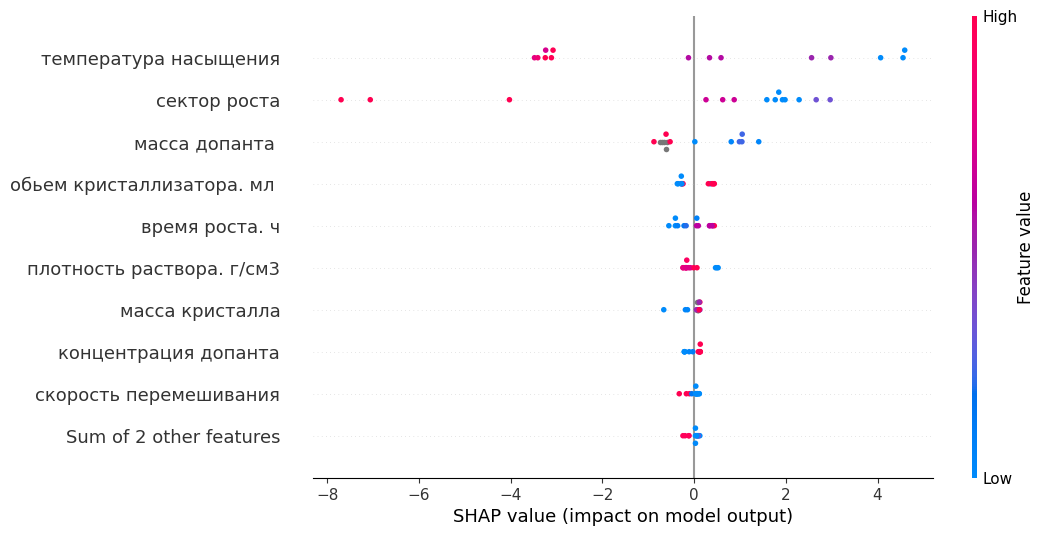

-2.7036638895670575
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}


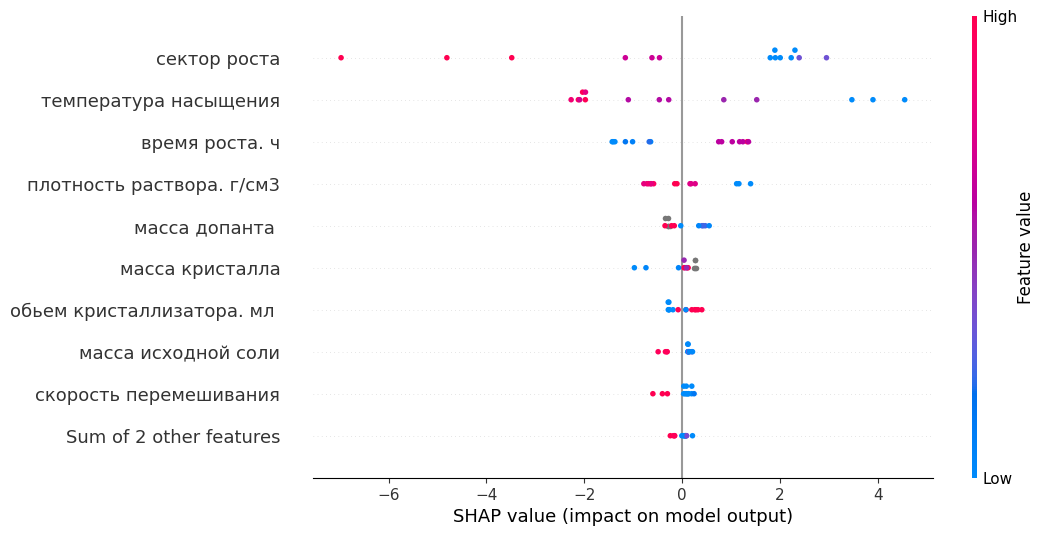

-5.320896657307943
{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


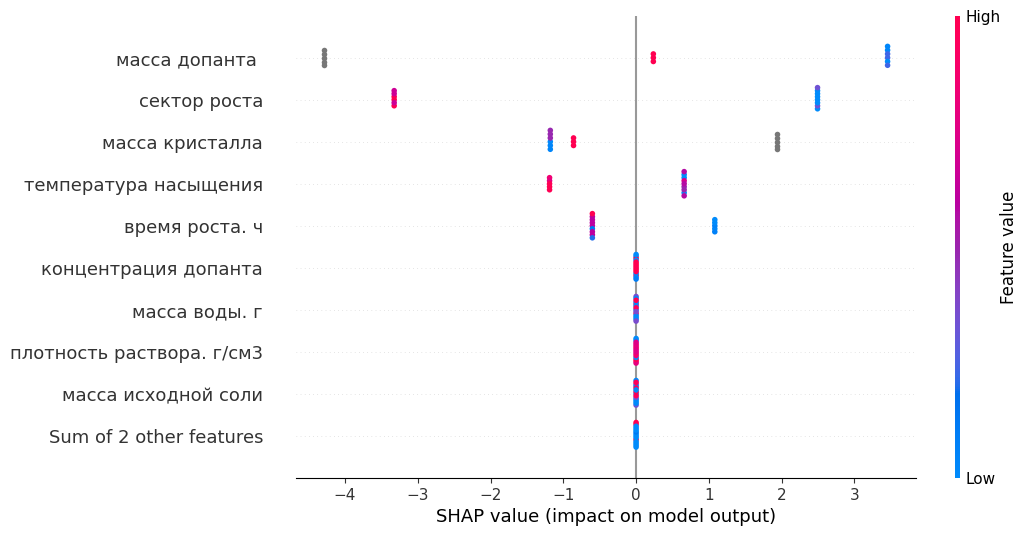

-3.4937138875325524
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}


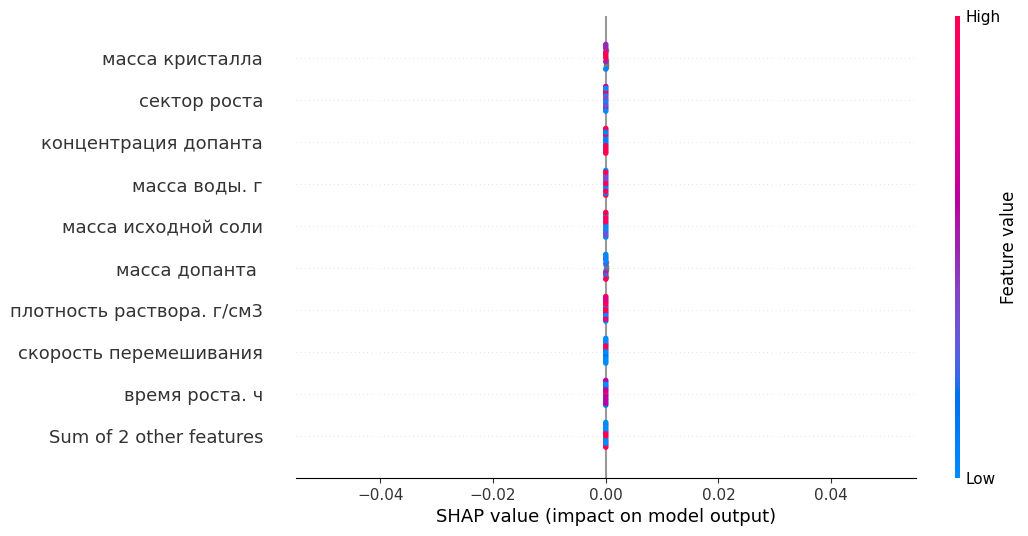

-3.499457041422526
{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}


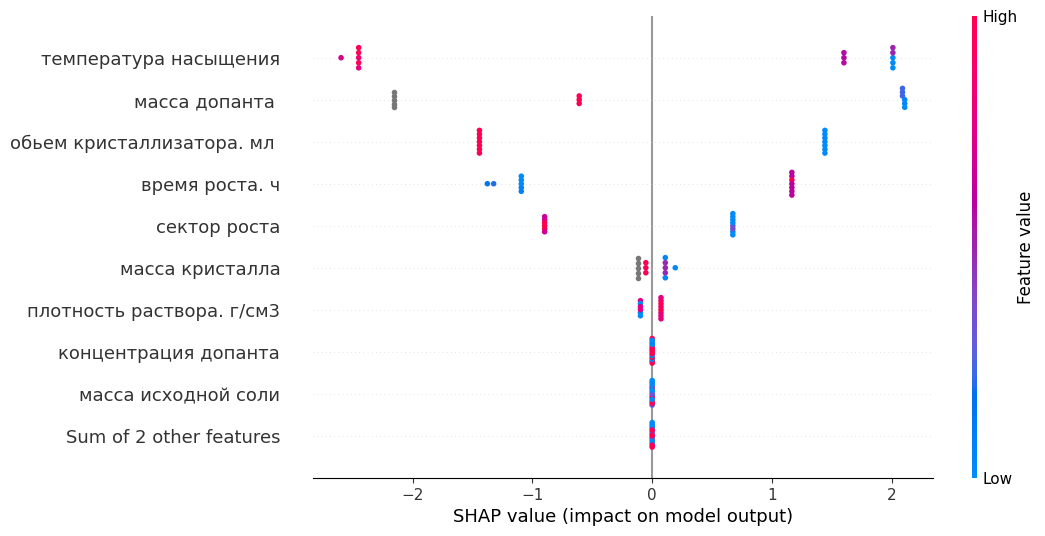

-3.2171300252278643
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6}


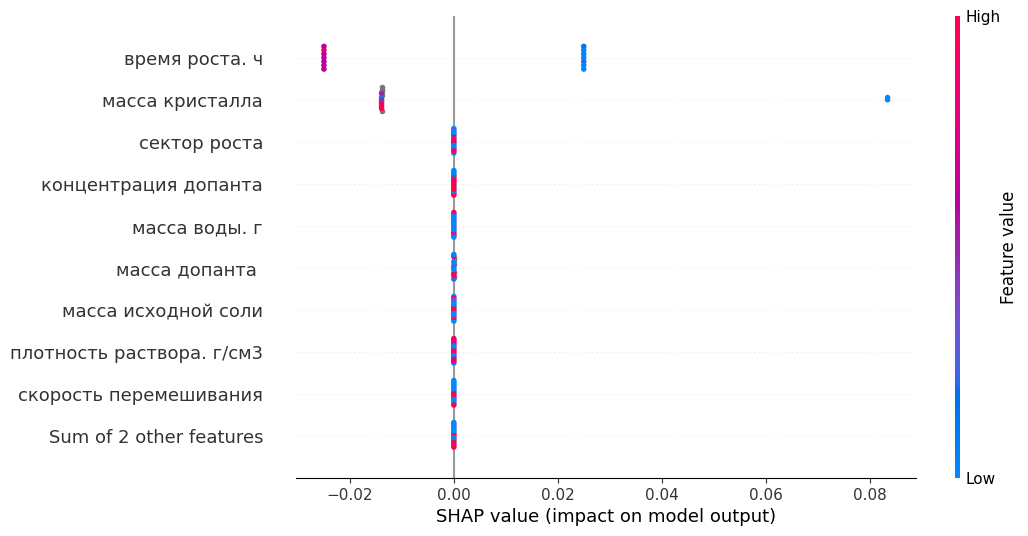

-4.729238128662109
{'colsample_bytree': 0.6, 'gamma': 2.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}


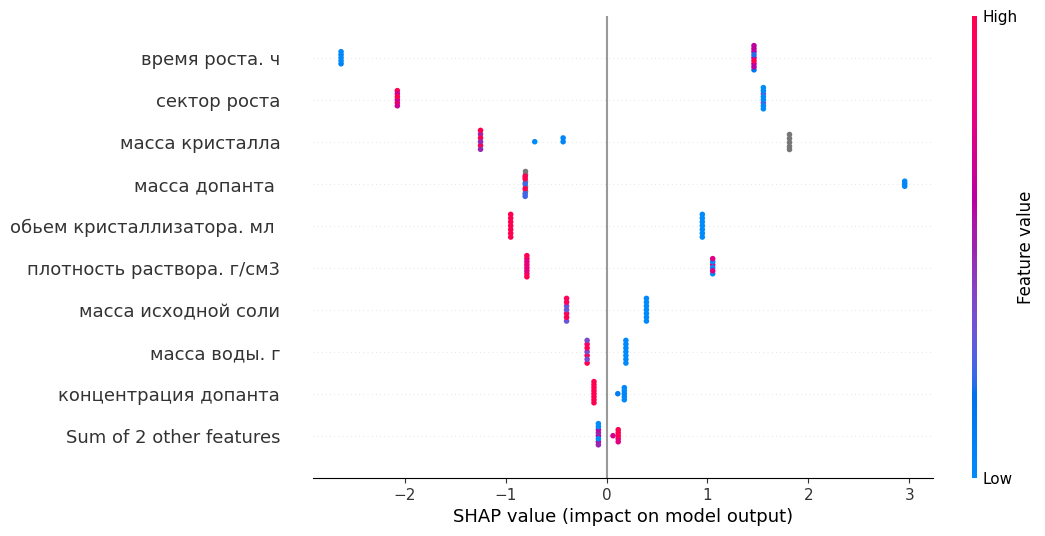

-8.583515548706053
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


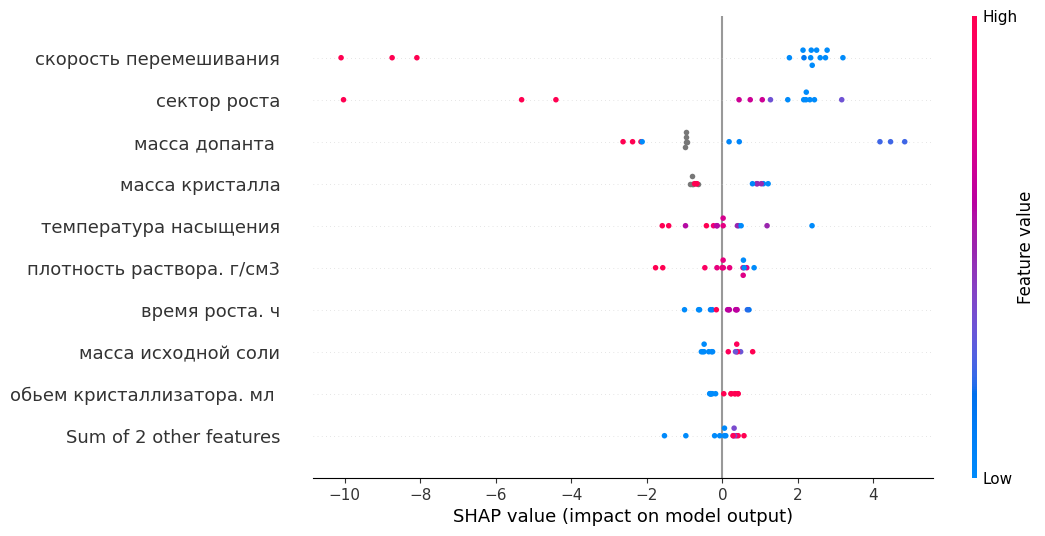

In [28]:
for col in y:
    best_model = learn_xgboost(X, y[col])
    explain(best_model, name=col, is_save=True, color_bar=True)